# git2net - Mining Time-Stamped Co-Editing Networks from Large git Repositories

In this notebook we provide the code to reproduce the figures for the Open Source Software project `igraph` shown in our paper "git2net - Mining Time-Stamped Co-Editing Networks from Large git Repositories" (presented at MSR 2019).

It also serves as a tutorial showing how git2net can be used to mine git repositories, generate network representations of the data, and extract various plots.

In [1]:
import git2net
import pathpy as pp
import pandas as pd
import sqlite3
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict

## Mining git Repositories

We first generate a database containing all co-editing relationships present in the data. For this, we also provide a clone of the `igraph` repository from the time of creating the paper in the folder "igraph". We save the extracted data in an sqlite database.

In [2]:
repo_string = 'igraph'
sqlite_db_file = 'igraph.db'

In [3]:
git2net.mine_git_repo(repo_string, sqlite_db_file)

Using 8 workers.


100% (5797 of 5797) |####################| Elapsed Time: 0:17:14 Time:  0:17:14


## Modification of Database

Given the database file, we now use some insights we have on the repository to improve the results of our subsequent analysis. Particularly, we merge the aliases of different authors.

In [4]:
con = sqlite3.connect(sqlite_db_file)

data = pd.read_sql("""SELECT * FROM commits""", con)

data = data.replace('Nepusz Tamas', 'Tamas Nepusz')
data = data.replace('Tamás Nepusz', 'Tamas Nepusz')
data = data.replace('ntamas', 'Tamas Nepusz')
data = data.replace('Gábor Csárdi', 'Gabor Csardi')
data = data.replace('Szabolcs Horvát', 'Szabolcs Horvat')
data = data.replace('Szabolcs Horvát', 'Szabolcs Horvat')
data = data.replace('Nam Lee', 'Nam H. Lee')

data.to_sql('commits', con, if_exists='replace')

## Network Generation

We now show how different types of networks can be generated from the database. The networks exorted with `git2net` are `pathpy` objects that can be converted and used with other network visualisation and analysis tools if desired.

### Co-editing Network

We start by extracting the co-editing network. Here, `git2net` returns a `pathpy` temporal network object that we convert to a startard time-aggregated network before visualising it.

In [5]:
t = git2net.get_coediting_network(sqlite_db_file)

n = pp.Network.from_temporal_network(t)

pp.visualisation.plot(n, width=800, height=800, node_color='#73D2DE')
pp.visualisation.export_html(n, '7a.html', width=1200, height=1000, node_color='#73D2DE', label_opacity=0.0,
                             node_size=10.0, edge_width=1.0)

With this we reproduce Figure 7a.

### DAG of Commits Edits

Next we look at DAG connecting a two commits if lines added in one are modified in the other.

In [6]:
dag = git2net.get_dag(sqlite_db_file, filename='flow.c')
    
colors = {}
for x in dag.nodes:
    colors[x] = '#FBB13C'
for x in dag.roots:
    colors[x] = '#a83236'
for x in dag.leafs:
    colors[x] = '#218380'

pp.visualisation.plot(dag, width=800, height=800, node_color=colors)
pp.visualisation.export_html(dag, '7b.html', width=1200, height=1000, node_color=colors, label_opacity=0.0,
                             node_size=10.0, edge_width=1.0)

With this we reproduce Figure 7b.

### Developer-File Network

Finally, we look at the bipartite network linking developers and the files they edited

In [7]:
t, colors = git2net.get_bipartite_network(sqlite_db_file, time_from=datetime(2016,1,1), time_to=datetime(2016,12,31))

n = pp.Network.from_temporal_network(t)

pp.visualisation.plot(n, width=800, height=800, node_color=colors)
pp.visualisation.export_html(n, '7c.html', width=1200, height=1000, node_color=colors, label_opacity=0.0,
                             node_size=10.0, edge_width=1.0)

With this we reproduce Figure 7c.

## Comparison Co-Editing and Co-Authorship Networks

We first generate the co-authorship and co-editing networks.

In [8]:
n_coauthorship = git2net.get_coauthorship_network(sqlite_db_file)
n_coauthorship

In [9]:
n_coediting = git2net.get_coediting_network(sqlite_db_file)
n_coediting = pp.Network.from_temporal_network(n_coediting)
n_coediting

In [10]:
print('==============================================')
print('# co-authorship')
print(n_coauthorship)
print('# co-editing')
print(n_coediting)
print('==============================================')

# co-authorship
Undirected network
Nodes:				24
Links:				67

# co-editing
Directed network
Nodes:				24
Links:				55



Next, we look at the relationship over time. We do this manually as this way we only need to querry the database once. This significantly reduces computation time.

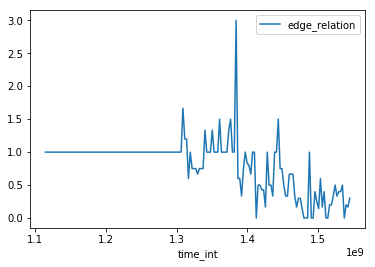

In [11]:
#%% IGRAPH FILES
con = sqlite3.connect('igraph.db')
edits = pd.read_sql("""SELECT pre_commit, post_commit, mod_filename FROM coedits""", con)
commits = pd.read_sql("""SELECT hash, author_name, author_date AS time FROM commits""", con)

edits.loc[:, 'pre_commit'] = edits.pre_commit.apply(lambda x: x[:7])
edits.loc[:, 'post_commit'] = edits.post_commit.apply(lambda x: x[:7])
commits.loc[:, 'hash'] = commits.hash.apply(lambda x: x[:7])

data_pre = pd.merge(edits, commits, how='left', left_on='pre_commit', right_on='hash') \
                .drop(['pre_commit', 'post_commit', 'hash'], axis=1)
data_post = pd.merge(edits, commits, how='left', left_on='post_commit', right_on='hash') \
                .drop(['pre_commit', 'post_commit', 'hash'], axis=1)
data = pd.concat([data_pre, data_post])

data_igraph_files = data

#%% IGRAPH COEDITS
con = sqlite3.connect('igraph.db')
edits = pd.read_sql("""SELECT pre_commit, post_commit FROM coedits""", con).drop_duplicates()
commits = pd.read_sql("""SELECT hash, author_name, author_date FROM commits""", con)

edits.loc[:, 'post_commit'] = edits.post_commit.apply(lambda x: x[:7])
edits.loc[:, 'pre_commit'] = edits.pre_commit.apply(lambda x: x[:7])

commits.loc[:, 'hash'] = commits.hash.apply(lambda x: x[:7])

data = pd.merge(edits, commits, how='left', left_on='pre_commit', right_on='hash') \
                .drop(['pre_commit', 'hash', 'author_date'], axis=1)
data.columns = ['post_commit', 'pre_author']
data = pd.merge(data, commits, how='left', left_on='post_commit', right_on='hash') \
                .drop(['post_commit', 'hash'], axis=1)
data.columns = ['pre_author', 'post_author', 'time']
data = data[['pre_author', 'post_author', 'time']]

data_igraph_coedits = data


#%%
data_igraph_files.index = pd.DatetimeIndex(data_igraph_files.time)
data_igraph_coedits.index = pd.DatetimeIndex(data_igraph_coedits.time)
data_igraph_files = data_igraph_files.drop(['time'], axis=1)
data_igraph_coedits = data_igraph_coedits.drop(['time'], axis=1)

#%% PLOT IGRAPH
plot_data = pd.DataFrame()

windowsize = timedelta(days=90)
increment = timedelta(days=30)

time = max(min(data_igraph_files.index), min(data_igraph_coedits.index)) + windowsize
while time < min(max(data_igraph_files.index), max(data_igraph_coedits.index)):
    mask_files = (data_igraph_files.index > time - windowsize) & (data_igraph_files.index <= time)
    mask_coedits = (data_igraph_coedits.index > time - windowsize) & (data_igraph_coedits.index <= time)

    wdata_files = data_igraph_files.loc[mask_files]
    wdata_coedits = data_igraph_coedits.loc[mask_coedits]

    wdata_files = wdata_files.drop_duplicates()
    wdata_coedits = wdata_coedits.drop_duplicates()

    n_files = pp.Network()
    for file in wdata_files.mod_filename.unique():
        n_files.add_clique(list(wdata_files.loc[wdata_files.mod_filename==file,'author_name']))
    files_edgecount = n_files.ecount()

    n_coedits = pp.Network()
    for idx, row in wdata_coedits.iterrows():
        if not row['post_author'] == row['pre_author']:
            n_coedits.add_edge(row['post_author'], row['pre_author'], directed=True)
    coedits_edgecount = n_coedits.ecount()

    if coedits_edgecount == 0:
        if files_edgecount == 0:
            plot_data = plot_data.append({'time': time, 'edge_relation': 1}, ignore_index=True)
        else:
            plot_data = plot_data.append({'time': time, 'edge_relation': np.inf}, ignore_index=True)
    else:
        plot_data = plot_data.append({'time': time, 'edge_relation': files_edgecount/coedits_edgecount},
                                     ignore_index=True)

    time += increment

plot_data.loc[:, 'time_int'] = plot_data.time.apply(lambda x: x.value * 1e-9)
plot_data.plot(x='time_int', y='edge_relation')

With this we reproduce Figure 8.

## Time Series Analysis

We now show how a variety of time series features can be extracted an plotted over time

In [12]:
WINDOW_SIZE = 365*24*60*60
STEP_SIZE = 30*24*60*60

In [13]:
def get_degree_centralisation(network, normalised=True):
    degrees = list(network.degrees())
    centralisation = sum([max(degrees) - x for x in degrees])
    n_edges = network.ecount()
    n_nodes = network.ncount()
    if n_edges == 0:
        return np.nan
    elif normalised:
        # also works if there are too few edges to make the network connected
        theoretical_degrees = [n_edges, n_edges-n_nodes+2] + [1 for x in range(n_nodes - 2)]
        theoretical_max_centralisation = sum([max(theoretical_degrees) - x for x in theoretical_degrees])
        if centralisation == theoretical_max_centralisation:
            return 1
        else:
            return centralisation/theoretical_max_centralisation
    else:
        return centralisation

In [14]:
def generate_plots(t):
    data = defaultdict(list)
    for network, window in pp.RollingTimeWindow(t, window_size=WINDOW_SIZE, step_size=STEP_SIZE,
                                                directed=True, return_window=True):
        data['number of developers'].append(network.ncount())
        data['unique relations directed'].append(network.ecount())
        data['mean outdegree'].append(pp.algorithms.statistics.mean_degree(network, degree='outdegree'))
        data['degree centralisation'].append(get_degree_centralisation(network))
        data['time'].append(window[1]) # append window end time
        
    # Plot time-variable network measures
    df = pd.DataFrame(data, columns=list(data.keys()))

    #
    df.set_index(pd.to_datetime(df.time, unit='s'), inplace=True)
    df.drop('time', axis=1, inplace=True)

    df.plot(y='number of developers')
    df.plot(y='unique relations directed')
    df.plot(y='mean outdegree')
    df.plot(y='degree centralisation')

In [15]:
n_coediting = git2net.get_coediting_network(sqlite_db_file)

=== IGRAPH ============================================


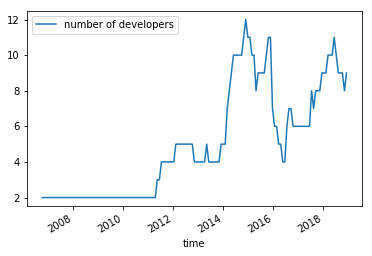

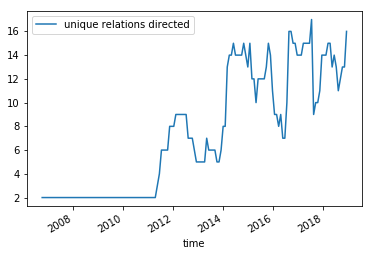

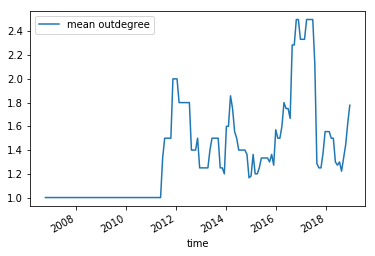

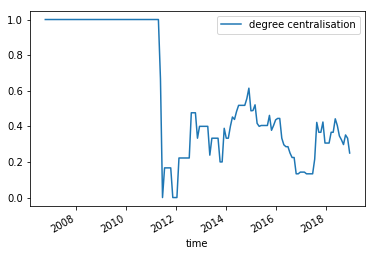

In [16]:
print('=== IGRAPH ============================================')
generate_plots(n_coediting)

With this we reproduce Figure 9.

## Editing of Foreign and Own Code

We now analyse the editing of foreign and own code over time.

In [18]:
con = sqlite3.connect(sqlite_db_file)
edits = pd.read_sql("""SELECT pre_commit, post_commit, post_chunk_len_in_chars, levenshtein_dist FROM coedits""",
                    con).drop_duplicates()
commits = pd.read_sql("""SELECT hash, author_name, author_date FROM commits""", con)

# for this analysis pure deletion of code is not considered
edits = edits.loc[(edits.post_chunk_len_in_chars!=0) & (pd.isnull(edits.levenshtein_dist)==False),
                  ['pre_commit', 'post_commit', 'levenshtein_dist']]

edits.loc[:, 'post_commit'] = edits.post_commit.apply(lambda x: x[:7])
edits.loc[:, 'pre_commit'] = edits.pre_commit.apply(lambda x: x[:7])

commits.loc[:, 'hash'] = commits.hash.apply(lambda x: x[:7])

data = pd.merge(edits, commits, how='left', left_on='pre_commit', right_on='hash') \
                .drop(['pre_commit', 'hash', 'author_date'], axis=1)
data.columns = ['post_commit', 'levenshtein_dist', 'pre_author']
data = pd.merge(data, commits, how='left', left_on='post_commit', right_on='hash') \
                .drop(['post_commit', 'hash'], axis=1)
data.columns = ['levenshtein_dist', 'pre_author', 'post_author', 'time']
data = data[['pre_author', 'post_author', 'time', 'levenshtein_dist']]

In [ ]:
data.index = pd.DatetimeIndex(data.time)
data = data.drop(['time'], axis=1)

plot_data = pd.DataFrame()

windowsize = timedelta(days=90)
increment = timedelta(days=30)

time = min(data.index) + windowsize
while time < max(data.index):
    mask = (data.index > time - windowsize) & (data.index <= time)
    wdata = data.loc[mask]
    self_changes = 0
    self_changes_dist = 0
    foreign_changes = 0
    foreign_changes_dist = 0
    for idx, row in wdata.iterrows():
        if row['pre_author'] == row['post_author']:
            self_changes += 1
            self_changes_dist += row['levenshtein_dist']
        else:
            foreign_changes += 1
            foreign_changes_dist += row['levenshtein_dist']
    active_authors = len(wdata.post_author.unique())
    plot_data = plot_data.append({'time': time,
                                  'active_authors': active_authors,
                                  'self_changes': self_changes,
                                  'self_changes_dist': self_changes_dist,
                                  'foreign_changes': foreign_changes,
                                  'foreign_changes_dist': foreign_changes_dist}, ignore_index=True)
    time += increment

plot_data.loc[:, 'foreign_changes_norm'] = plot_data.foreign_changes / (plot_data.foreign_changes +
                                                                        plot_data.self_changes)
plot_data.loc[:, 'self_changes_norm'] = plot_data.self_changes / (plot_data.foreign_changes +
                                                                  plot_data.self_changes)
plot_data.loc[:, 'foreign_changes_dist_norm'] = plot_data.foreign_changes_dist / (plot_data.foreign_changes_dist +
                                                                                  plot_data.self_changes_dist)
plot_data.loc[:, 'self_changes_dist_norm'] = plot_data.self_changes_dist / (plot_data.foreign_changes_dist +
                                                                            plot_data.self_changes_dist)

plot_data.plot(x='time', y='active_authors')
plot_data.plot(x='time', y=['self_changes', 'foreign_changes'])
plot_data.plot(x='time', y=['self_changes_norm', 'foreign_changes_norm'], kind='area')
plot_data.plot(x='time', y=['self_changes_dist', 'foreign_changes_dist'])
plot_data.plot(x='time', y=['self_changes_dist_norm', 'foreign_changes_dist_norm'], kind='area')

With this we reproduce Figure 10.

## Scalability Analysis

Lastly, we report detailed results of our scalability analysis as well as code to reproduce the figure.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

res = pd.DataFrame()
res = res.append({'cores': 1, 't1': '59:12', 't2': '59:36', 't3': '59:29'}, ignore_index=True)
res = res.append({'cores': 2, 't1': '29:13', 't2': '29:21', 't3': '29:21'}, ignore_index=True)
res = res.append({'cores': 3, 't1': '19:36', 't2': '19:42', 't3': '19:41'}, ignore_index=True)
res = res.append({'cores': 4, 't1': '14:46', 't2': '14:51', 't3': '14:47'}, ignore_index=True)
res = res.append({'cores': 5, 't1': '11:50', 't2': '11:55', 't3': '11:53'}, ignore_index=True)
res = res.append({'cores': 6, 't1': '09:56', 't2': '09:57', 't3': '09:56'}, ignore_index=True)
res = res.append({'cores': 7, 't1': '08:34', 't2': '08:36', 't3': '08:33'}, ignore_index=True)
res = res.append({'cores': 8, 't1': '07:31', 't2': '07:33', 't3': '07:31'}, ignore_index=True)
res = res.append({'cores': 9, 't1': '06:43', 't2': '06:43', 't3': '06:43'}, ignore_index=True)
res = res.append({'cores': 10, 't1': '06:05', 't2': '06:06', 't3': '06:05'}, ignore_index=True)
res = res.append({'cores': 11, 't1': '05:34', 't2': '05:36', 't3': '05:34'}, ignore_index=True)
res = res.append({'cores': 12, 't1': '05:10', 't2': '05:11', 't3': '05:10'}, ignore_index=True)
res = res.append({'cores': 13, 't1': '04:49', 't2': '04:51', 't3': '04:50'}, ignore_index=True)
res = res.append({'cores': 14, 't1': '04:34', 't2': '04:34', 't3': '04:33'}, ignore_index=True)
res = res.append({'cores': 15, 't1': '04:20', 't2': '04:20', 't3': '04:20'}, ignore_index=True)
res = res.append({'cores': 16, 't1': '04:08', 't2': '04:08', 't3': '04:08'}, ignore_index=True)
res = res.append({'cores': 17, 't1': '03:58', 't2': '03:55', 't3': '03:58'}, ignore_index=True)
res = res.append({'cores': 18, 't1': '03:48', 't2': '03:47', 't3': '03:49'}, ignore_index=True)
res = res.append({'cores': 19, 't1': '03:41', 't2': '03:38', 't3': '03:41'}, ignore_index=True)
res = res.append({'cores': 20, 't1': '03:35', 't2': '03:33', 't3': '03:36'}, ignore_index=True)
res = res.append({'cores': 21, 't1': '03:31', 't2': '03:29', 't3': '03:31'}, ignore_index=True)
res = res.append({'cores': 22, 't1': '03:27', 't2': '03:25', 't3': '03:26'}, ignore_index=True)
res = res.append({'cores': 23, 't1': '03:23', 't2': '03:21', 't3': '03:22'}, ignore_index=True)
res = res.append({'cores': 24, 't1': '03:18', 't2': '03:17', 't3': '03:18'}, ignore_index=True)
res = res.append({'cores': 25, 't1': '03:15', 't2': '03:13', 't3': '03:15'}, ignore_index=True)
res = res.append({'cores': 26, 't1': '03:13', 't2': '03:12', 't3': '03:12'}, ignore_index=True)
res = res.append({'cores': 27, 't1': '03:11', 't2': '03:10', 't3': '03:11'}, ignore_index=True)
res = res.append({'cores': 28, 't1': '03:11', 't2': '03:07', 't3': '03:10'}, ignore_index=True)
res = res.append({'cores': 29, 't1': '03:09', 't2': '03:06', 't3': '03:08'}, ignore_index=True)
res = res.append({'cores': 30, 't1': '03:09', 't2': '03:06', 't3': '03:08'}, ignore_index=True)
res = res.append({'cores': 31, 't1': '03:07', 't2': '03:06', 't3': '03:06'}, ignore_index=True)
res = res.append({'cores': 32, 't1': '03:06', 't2': '03:06', 't3': '03:06'}, ignore_index=True)
    
def tstr_to_min(tstr):
    return int(tstr[:2]) + int(tstr[-2:]) / 60

res.loc[:,'t1'] = res.t1.apply(tstr_to_min)
res.loc[:,'t2'] = res.t2.apply(tstr_to_min)
res.loc[:,'t3'] = res.t3.apply(tstr_to_min)

res['mean'] = res.loc[:,['t1', 't2', 't3']].mean(axis=1)
res['error'] = res.loc[:,['t1', 't2', 't3']].std(axis=1)

res['reference'] = [res['mean'][0] / i for i in range(1,33)]


plt.plot(res['cores'], res['reference'], 'gray')
plt.errorbar(res['cores'], res['mean'], yerr=res['error'], fmt='.')

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')

plt.show()

With this we reproduce Figure 6.